In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class PMAStrategy(bt.Strategy):

    def __init__(self):
        # Initialize SMA indicator
        self.sma = bt.indicators.SMA(self.data.close, period=10)  # You can change the period as desired
        self.order = None

    def next(self):
        if self.order:  # If there is an open order, do nothing
            return

        # Buy if Pt is greater than MAt(n)
        if not self.position and self.data.close[0] > self.sma[0]:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price
            if shares_to_buy > 0:            
                self.log('Kreiraj Kupnju, %.2f' % self.data.close[0])
                self.order = self.buy(size=shares_to_buy)

        # Sell if Pt is less than MAt(n)
        elif self.position and self.data.close[0] < self.sma[0]:
            self.log('Kreiraj Prodaju, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Izvršena KUPNJA (Cijena: %.2f, Vrijednost: %.2f, Provizija %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "Izvršena PRODAJA (Cijena: %.2f, Vrijednost: %.2f, Provizija %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Narudžba je otkazana/margina/odbijena")
        self.order = None


In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Download data and store it in a variable
    yf_data = yf.download(ticker, start=start_date, end=end_date)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0.0002)
    
    # Add observer to track portfolio value
    cerebro.addobserver(bt.observers.Value)
    
    # Add analyzer to track returns
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Početno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Završno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Get data from PyFolio analyzer
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Get portfolio values
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Create DataFrame with dates and portfolio values
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Use pyfolio to generate report
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

[*********************100%%**********************]  1 of 1 completed

Početno stanje portfelja: 100000.00
2024-01-16, Kreiraj Kupnju, 390.27
2024-01-17, Izvršena KUPNJA (Cijena: 387.98, Vrijednost: 99322.88, Provizija 19.86)
2024-01-31, Kreiraj Prodaju, 397.58
2024-02-01, Izvršena PRODAJA (Cijena: 401.83, Vrijednost: 99322.88, Provizija 20.57)
2024-02-01, Kreiraj Kupnju, 403.78
2024-02-02, Izvršena KUPNJA (Cijena: 403.81, Vrijednost: 103375.36, Provizija 20.68)
2024-02-13, Kreiraj Prodaju, 406.32
2024-02-14, Izvršena PRODAJA (Cijena: 408.07, Vrijednost: 103375.36, Provizija 20.89)
2024-02-22, Kreiraj Kupnju, 411.65
2024-02-23, Narudžba je otkazana/margina/odbijena
2024-02-23, Kreiraj Kupnju, 410.34
2024-02-26, Izvršena KUPNJA (Cijena: 411.46, Vrijednost: 104510.84, Provizija 20.90)
2024-02-26, Kreiraj Prodaju, 407.54
2024-02-27, Izvršena PRODAJA (Cijena: 407.99, Vrijednost: 104510.84, Provizija 20.73)
2024-02-27, Kreiraj Kupnju, 407.48
2024-02-28, Narudžba je otkazana/margina/odbijena
2024-02-28, Kreiraj Kupnju, 407.72
2024-02-29, Narudžba je otkazana/ma


/opt/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.136%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-01-02
End date,2024-07-30
Total months,6
,Backtest
Annual return,18.136%
Cumulative returns,10.065%
Annual volatility,13.197%
Sharpe ratio,1.33
Calmar ratio,2.43
Stability,0.52
Max drawdown,-7.454%


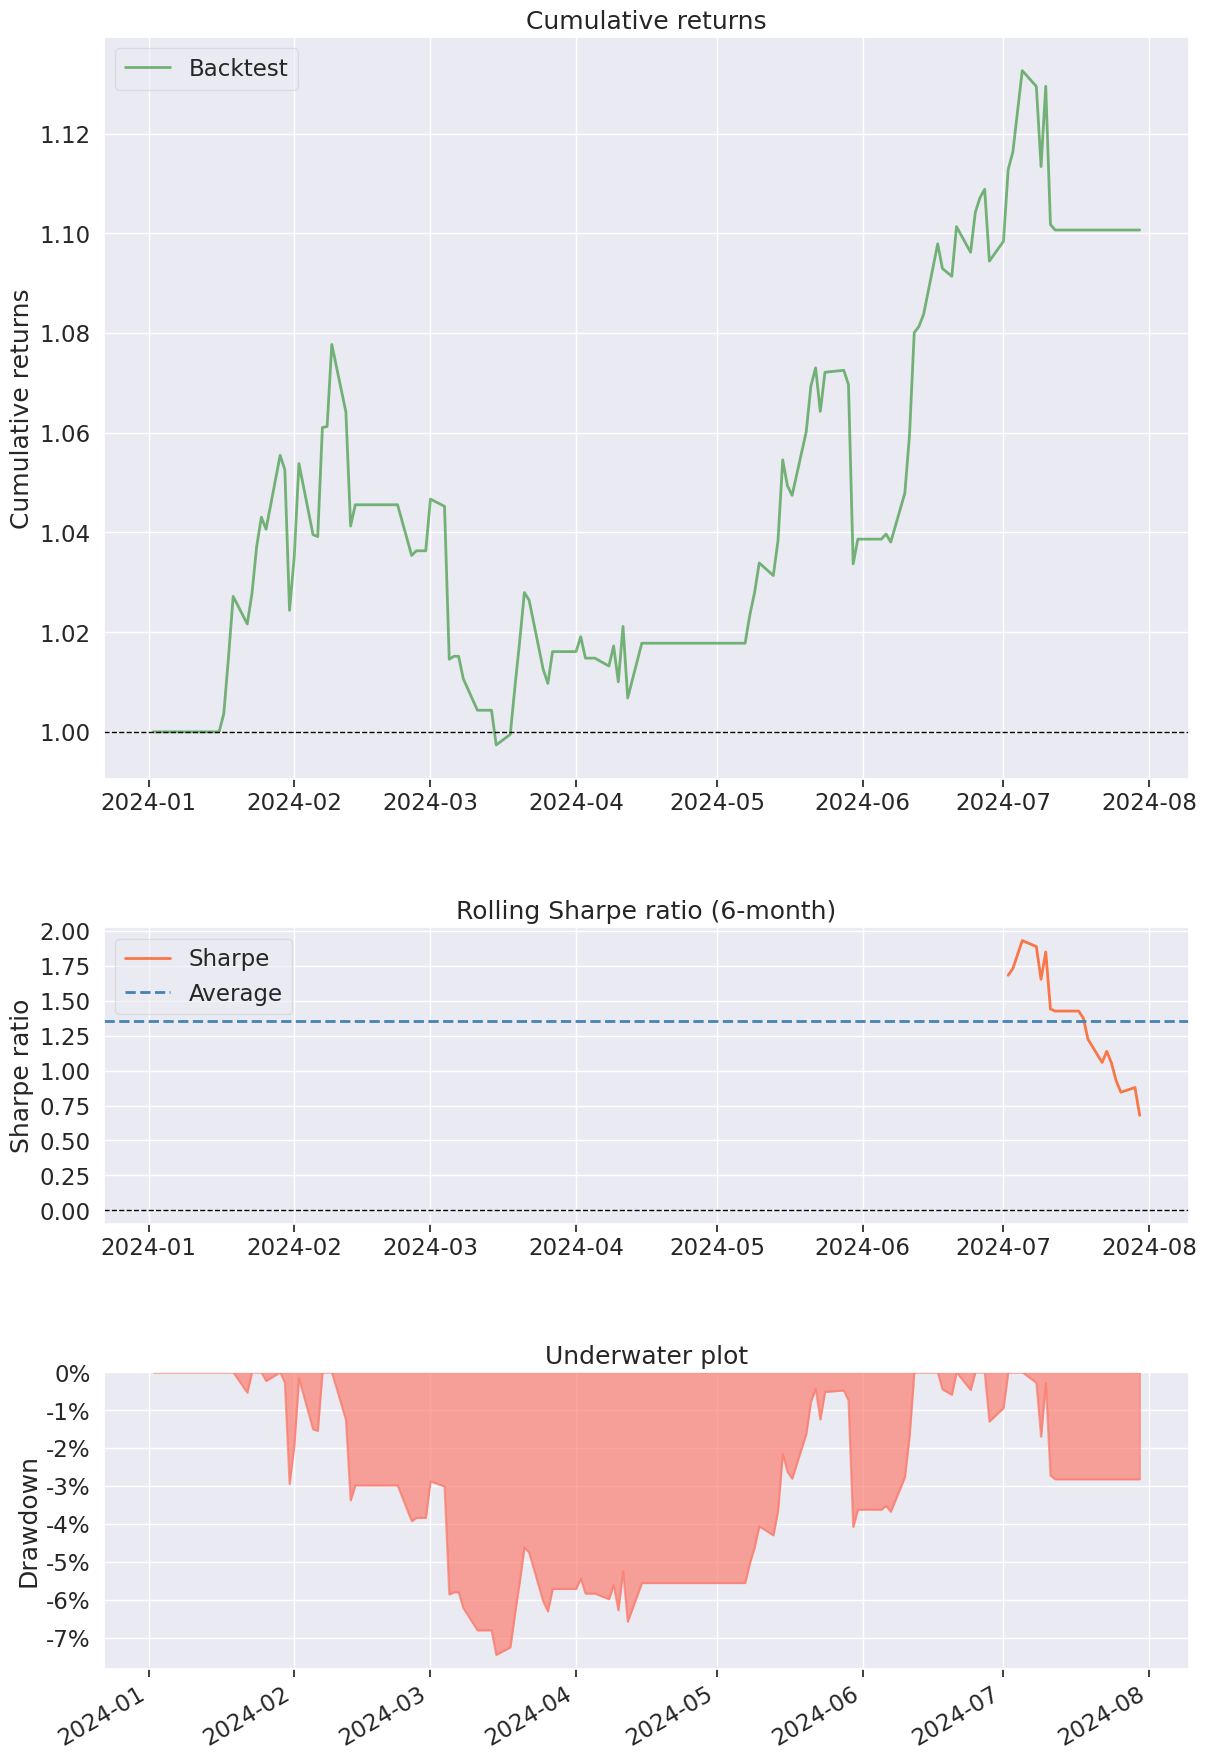

In [4]:
results = test_strategy(PMAStrategy, 'MSFT', '2024-01-01', '2024-07-31')

In [5]:
import pickle

# Za df_account_value_sac
with open('msft_p_ma_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)